# SAC BipedalWalker-2D



### Connect the notebook to the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os 
os.chdir('/content/drive/My Drive/RL/code/')

In [ ]:
import sys



In [ ]:
sys.path.append('/content/drive/My Drive/RL/code/')

## Install and import libraries

In [ ]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg
!pip install gym
!pip install 'imageio==2.4.0'
!pip install matplotlib
!pip install PILLOW
!pip install tf-agents[reverb]
!pip install pybullet
!pip install box2d-py
!pip install pyvirtualdisplay


In [ ]:
import base64
import imageio
import IPython
import matplotlib.pyplot as plt
import os
import reverb
import tempfile
import PIL.Image
import gym


import tensorflow as tf

from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent
from tf_agents.agents.sac import tanh_normal_projection_network
from tf_agents.environments import suite_pybullet
from tf_agents.experimental.train import actor
from tf_agents.experimental.train import learner
from tf_agents.experimental.train import triggers
from tf_agents.experimental.train.utils import spec_utils
from tf_agents.experimental.train.utils import strategy_utils
from tf_agents.experimental.train.utils import train_utils
from tf_agents.metrics import py_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import greedy_policy
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_py_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.environments import suite_gym
import pyvirtualdisplay

import base64


# tempdir = tempfile.gettempdir()
tempdir = 'temp_dir'

In [ ]:
from tf_agents.utils import common

## Hyperparameters

In [ ]:

env_name = "BipedalWalker-v3" # @param {type:"string"}

# Use "num_iterations = 1e6" for better results (2 hrs)
# 1e5 is just so this doesn't take too long (1 hr)
num_iterations = 200000 # @param {type:"integer"}

initial_collect_steps = 20000 # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_capacity = 1000000 # @param {type:"integer"}

batch_size = 256 # @param {type:"integer"}

critic_learning_rate = 1e-4 # @param {type:"number"}
actor_learning_rate = 1e-4 # @param {type:"number"}
alpha_learning_rate = 1e-4 # @param {type:"number"}
target_update_tau = 0.005 # @param {type:"number"}
target_update_period = 10 # @param {type:"number"}
gamma = 0.99 # @param {type:"number"}
reward_scale_factor = 1.0 # @param {type:"number"}

actor_fc_layer_params = (256, 256, 256, 128)
critic_joint_fc_layer_params = (256, 256 , 256, 128)

log_interval = 5000 # @param {type:"integer"}

num_eval_episodes = 20 # @param {type:"integer"}
eval_interval = 10000 # @param {type:"integer"}

policy_save_interval = 5000 # @param {type:"integer"}

## Environment

In [ ]:
tf.compat.v1.enable_v2_behavior()

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [ ]:
#env = suite_pybullet.load(env_name)
#env = gym.make(env_name)
env = suite_gym.load(env_name)
env.reset()
PIL.Image.fromarray(env.render())

In [ ]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

In [ ]:
# collect_env = suite_pybullet.load(env_name)
# eval_env = suite_pybullet.load(env_name)

collect_env = suite_gym.load(env_name)
eval_env = suite_gym.load(env_name)

## Distribution Strategy


In [ ]:
use_gpu = True #@param {type:"boolean"}

strategy = strategy_utils.get_strategy(tpu=False, use_gpu=use_gpu)

All variables and Agents need to be created under `strategy.scope()`, as you'll see below.

## Agent


In [ ]:
observation_fc_layer_params = (256, 256, 256, 128)
action_fc_layer_params = (256, 256, 256, 128)
observation_dropout_layer_params = (0.2, 0.2, 0.2, 0.2)
action_dropout_layer_params = (0.2, 0.2, 0.2, 0.2)

In [ ]:
observation_spec, action_spec, time_step_spec = (
      spec_utils.get_tensor_specs(collect_env))

with strategy.scope():
  critic_net = critic_network.CriticNetwork(
        (observation_spec, action_spec),
        # observation_fc_layer_params=observation_fc_layer_params,
        # observation_dropout_layer_params = observation_dropout_layer_params,
        # action_dropout_layer_params = action_dropout_layer_params,
        # action_fc_layer_params=action_fc_layer_params,
        joint_fc_layer_params=critic_joint_fc_layer_params,
        kernel_initializer='glorot_uniform',
        last_kernel_initializer='glorot_uniform')

In [ ]:
with strategy.scope():
  actor_net = actor_distribution_network.ActorDistributionNetwork(
      observation_spec,
      action_spec,
      fc_layer_params=actor_fc_layer_params,
      continuous_projection_net=(
          tanh_normal_projection_network.TanhNormalProjectionNetwork))

In [ ]:
with strategy.scope():
  train_step = train_utils.create_train_step()

  tf_agent = sac_agent.SacAgent(
        time_step_spec,
        action_spec,
        actor_network=actor_net,
        critic_network=critic_net,
        actor_optimizer=tf.compat.v1.train.AdamOptimizer(
            learning_rate=actor_learning_rate),
        critic_optimizer=tf.compat.v1.train.AdamOptimizer(
            learning_rate=critic_learning_rate),
        alpha_optimizer=tf.compat.v1.train.AdamOptimizer(
            learning_rate=alpha_learning_rate),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        td_errors_loss_fn=tf.math.squared_difference,
        gamma=gamma,
        reward_scale_factor=reward_scale_factor,
        train_step_counter=train_step)

  tf_agent.initialize()

#### Replay Buffer




In [ ]:
table_name = 'uniform_table'
table = reverb.Table(
    table_name,
    max_size=replay_buffer_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1))

reverb_server = reverb.Server([table])

In [ ]:
reverb_replay = reverb_replay_buffer.ReverbReplayBuffer(
    tf_agent.collect_data_spec,
    sequence_length=2,
    table_name=table_name,
    local_server=reverb_server)

In [ ]:
dataset = reverb_replay.as_dataset(
      sample_batch_size=batch_size, num_steps=2).prefetch(50)
experience_dataset_fn = lambda: dataset

#### Policies


In [ ]:
tf_eval_policy = tf_agent.policy
eval_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_eval_policy, use_tf_function=True)

In [ ]:
tf_collect_policy = tf_agent.collect_policy
collect_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_collect_policy, use_tf_function=True)

In [ ]:
random_policy = random_py_policy.RandomPyPolicy(
  collect_env.time_step_spec(), collect_env.action_spec())

#### Actors


In [ ]:
rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  reverb_replay.py_client,
  table_name,
  sequence_length=2,
  stride_length=1)

In [ ]:
initial_collect_actor = actor.Actor(
  collect_env,
  random_policy,
  train_step,
  steps_per_run=initial_collect_steps,
  observers=[rb_observer])
initial_collect_actor.run()

In [ ]:
env_step_metric = py_metrics.EnvironmentSteps()
collect_actor = actor.Actor(
  collect_env,
  collect_policy,
  train_step,
  steps_per_run=1,
  metrics=actor.collect_metrics(10),
  summary_dir=os.path.join(tempdir, learner.TRAIN_DIR),
  observers=[rb_observer, env_step_metric])

In [ ]:
eval_actor = actor.Actor(
  eval_env,
  eval_policy,
  train_step,
  episodes_per_run=num_eval_episodes,
  metrics=actor.eval_metrics(num_eval_episodes),
  summary_dir=os.path.join(tempdir, 'eval'),
)

#### Before training we have initialize a checkpointer to save and restore the training


In [ ]:
checkpoint_dir = os.path.join(tempdir, 'checkpoint1')

train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=tf_agent,
    policy=tf_agent.policy,
    replay_buffer=reverb_replay,
    global_step=train_step
)

In [ ]:
train_checkpointer.initialize_or_restore()
# train_step = train_utils.create_train_step()

## Learners


In [ ]:
saved_model_dir = os.path.join(tempdir, learner.POLICY_SAVED_MODEL_DIR)

# Triggers to save the agent's policy checkpoints.
learning_triggers = [
    triggers.PolicySavedModelTrigger(
        saved_model_dir,
        tf_agent,
        train_step,
        interval=policy_save_interval),
    triggers.StepPerSecondLogTrigger(train_step, interval=1000),
]

agent_learner = learner.Learner(
  tempdir,
  train_step,
  tf_agent,
  experience_dataset_fn,
  triggers=learning_triggers)

#### Metrics and Evaluation


In [ ]:
def get_eval_metrics():
  eval_actor.run()
  results = {}
  for metric in eval_actor.metrics:
    results[metric.name] = metric.result()
  return results

metrics = get_eval_metrics()

In [ ]:
def log_eval_metrics(step, metrics):
  eval_results = (', ').join(
      '{} = {:.6f}'.format(name, result) for name, result in metrics.items())
  print('step = {0}: {1}'.format(step, eval_results))

log_eval_metrics(0, metrics)

### Training the agent

In [ ]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = get_eval_metrics()["AverageReturn"]
returns = [avg_return]

for _ in range(num_iterations):
  # Training.
  collect_actor.run() ## Collect the experience 
  loss_info = agent_learner.run(iterations=1)  ## Run the agent to learn the parameters

  # Evaluating.
  step = agent_learner.train_step_numpy 

  if eval_interval and step % eval_interval == 0:
    metrics = get_eval_metrics()
    log_eval_metrics(step, metrics)
    returns.append(metrics["AverageReturn"])

  if log_interval and step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, loss_info.loss.numpy()))

rb_observer.close()
reverb_server.stop()

#### Save the model using checkpointer 

In [ ]:
train_step

MirroredVariable:{
  0: <tf.Variable 'Variable:0' shape=() dtype=int64, numpy=200000>
}

In [ ]:
train_checkpointer.save(train_step)

In [ ]:
import numpy as np

In [ ]:
run_number = 2

In [ ]:
np.save(file= f'./results/run{run_number}.npy', arr= returns)

In [ ]:
len(returns)

21

### Restore the checkpoint

In [ ]:
train_checkpointer.initialize_or_restore()
# train_step = train_utils.create_train_step()

## Visualization


### Plots


In [ ]:
#@test {"skip": true}

steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.title('Average Return vs Step')
plt.ylim()
plt.savefig(f'./avg_return_plot{run_number}.png')

### Videos

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [ ]:
num_episodes = 4
video_filename = 'sac_bipedal.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_env.render())
    while not time_step.is_last():
      action_step = eval_actor.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_env.render())

embed_mp4(video_filename)

### Comparison plot between SAC and DDPG

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
sac_run_number = 2
ddpg_run_number = 1

In [ ]:
sac_results_returns =np.load(file= f'./results/run{sac_run_number}.npy')
ddpg_results_returns = np.load(file= f'./ddpg_results/avg_ep_reward_list_run{ddpg_run_number}.npy')
ddpg_results_steps = np.load(file= f'./ddpg_results/step_num_list_run{ddpg_run_number}.npy')

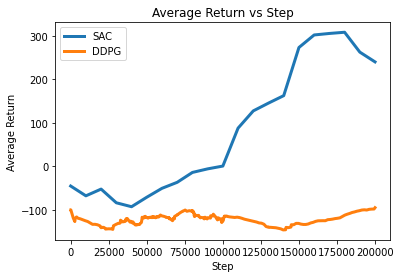

In [ ]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, sac_results_returns, label = 'SAC', linewidth = 3)
plt.plot(ddpg_results_steps, ddpg_results_returns, label = 'DDPG', linewidth = 3)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.title('Average Return vs Step')
plt.ylim()
plt.legend()
plt.savefig(f'./comparison_plot_soft_terrain.png')